In [2]:
import os
import glob
import keras
import librosa.display

import numpy as np
import pandas as pd
import IPython.display as ipd

from keras.models import Sequential
from keras.callbacks import ModelCheckpoint
from keras.utils import to_categorical, np_utils
from keras.utils.vis_utils import plot_model
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Dense, Activation, Dropout, Flatten, Conv2D, MaxPooling2D
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

Using TensorFlow backend.


# Data Analysis

## Listening

In [3]:
directory = "data2/audio/"

In [4]:
# Bed
word = "bed/"
filename_bed = "00176480_nohash_0"

ipd.Audio(os.path.normcase(directory+word+filename_bed+".wav"))

In [5]:
# Cat
word = "cat/"
filename_cat = "00f0204f_nohash_0"

ipd.Audio(os.path.normcase(directory+word+filename_cat+".wav"))

In [6]:
# Happy
word = "happy/"
filename_happy = "0ac15fe9_nohash_0"

ipd.Audio(os.path.normcase(directory+word+filename_happy+".wav"))

## Waveplot

In [7]:
% pylab inline


def waveplot(file, word):
    data, sampling_rate = librosa.load(os.path.normcase(directory+word+"/"+file+".wav"))
    print("Word:"+word)
    print("Sampling rate:", sampling_rate)
    plt.figure(figsize=(12, 4))
    librosa.display.waveplot(data, sr=sampling_rate)
    plt.xlabel("Time (s)")
    plt.ylabel("Amplitude (dB)")
    plt.title("Signal wave from "+word+"/"+file+" file")
    plt.savefig("plot"+word+".png", dpi=300)

Populating the interactive namespace from numpy and matplotlib


Word:bed
Sampling rate: 22050


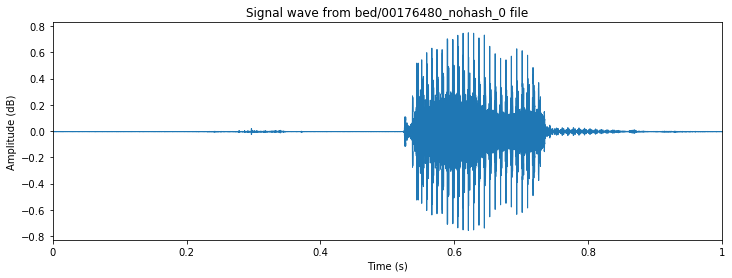

In [8]:
# Bed
word = "bed"
waveplot(filename_bed, word)

Word:cat
Sampling rate: 22050


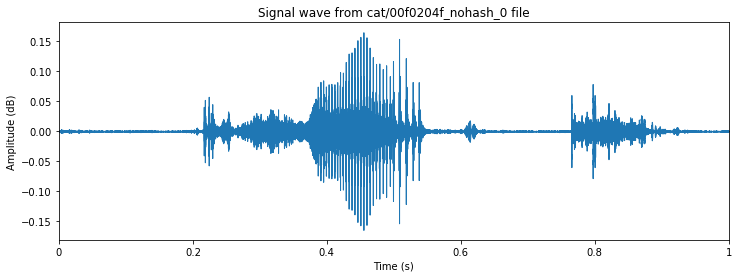

In [9]:
# Cat
word = "cat"
waveplot(filename_cat, word)

Word:happy
Sampling rate: 22050


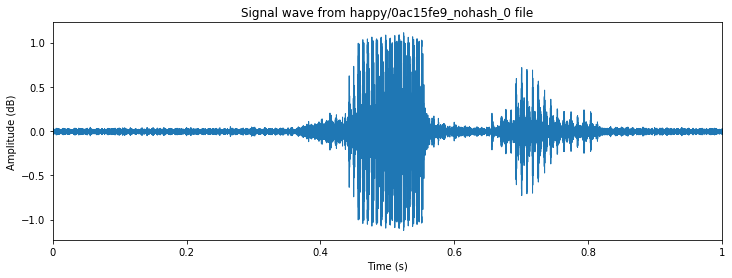

In [10]:
# Happy
word = "happy"
waveplot(filename_happy, word)

# Preprocessing Audio Files

## Creating a DataFrame

In [11]:
words = os.listdir(directory)
temps = []
for word in words:
    for wavfile in os.listdir(directory + '/' + word):
        idWAV = wavfile.replace(".wav", "")
        temps.append({"ID": idWAV, "Word": word})
df = pd.DataFrame(temps, columns=["ID", "Word"])

In [12]:
def wav2mfcc(row, max_len=11):
    file = os.path.normcase(directory+row.Word+"/"+row.ID + '.wav')

    try:
        wave, sr = librosa.load(file, mono=True, sr=None)
        wave = wave[::3]
        mfcc = librosa.feature.mfcc(wave, sr=sr)

        # If maximum length exceeds mfcc lengths then pad the remaining ones
        if (max_len > mfcc.shape[1]):
            pad_width = max_len - mfcc.shape[1]
            mfcc = np.pad(mfcc, pad_width=((0, 0), (0, pad_width)), mode='constant')

        # Else cutoff the remaining parts
        else:
            mfcc = mfcc[:, :max_len]
    except Exception as e:
        print("Error encountered while parsing file: ", file)
        return None, None
    
    return [mfcc, row.Word]

In [13]:
df_temp = df.apply(wav2mfcc, axis=1)

In [14]:
df_temp.columns = ['feature', 'label']

In [15]:
# Number of words
len(df_temp.label.value_counts())

30

In [16]:
# Number min of samples of a word
min(df_temp.label.value_counts())

1713

## Convert the data

In [17]:
x = np.array(df_temp.feature.tolist())
y = np.array(df_temp.label.tolist())

In [18]:
lb = LabelEncoder()
y = np_utils.to_categorical(lb.fit_transform(y))

channel = 1

#Reshaping to perform 2D convolution
x = x.reshape(x.shape[0], x.shape[1], x.shape[2], channel)

In [19]:
np.save("x_cnn.npy", x)
np.save("y_cnn.npy", y)

# Build Model

## Break Dataset into Training and Testing Sets

In [20]:
test_size = 0.30
random_state = 42

x = np.load("x_cnn.npy")
y = np.load("y_cnn.npy")

In [21]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=test_size, random_state=random_state)

# print number of training and test images
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

45304 train samples
19417 test samples


## Model Architecture

In [22]:
num_classes = y_train.shape[1]
input_shape = x_train.shape[1:]

In [23]:
model = Sequential()
model.add(Conv2D(32, kernel_size=(2, 2), activation='relu', input_shape=input_shape))
model.add(Conv2D(48, kernel_size=(2, 2), activation='relu'))
model.add(Conv2D(120, kernel_size=(2, 2), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.25))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.4))
model.add(Dense(num_classes, activation='softmax'))

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 19, 10, 32)        160       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 18, 9, 48)         6192      
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 17, 8, 120)        23160     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 8, 4, 120)         0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 8, 4, 120)         0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 3840)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               491648    
__________


## Compile the Model

In [24]:
model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adadelta(),
              metrics=['accuracy'])

# Train the Model

In [25]:
batch_size = 32
epochs = 100
verbose = 1
validation_split = 0.3

In [ ]:
# train the model
checkpointer = ModelCheckpoint(filepath='audio_model_cnn.weights.best.hdf5', verbose=1, 
                               save_best_only=True)

model.fit(x=x_train, y=y_train, batch_size=batch_size, epochs=epochs, verbose=verbose, callbacks=[checkpointer],
    validation_split=validation_split)

Train on 31712 samples, validate on 13592 samples
Epoch 1/100
31712/31712 [==============================] - 25s - loss: 3.2554 - acc: 0.0893 - val_loss: 2.6556 - val_acc: 0.2732
Epoch 2/100
31712/31712 [==============================] - 24s - loss: 2.5946 - acc: 0.2426 - val_loss: 1.8979 - val_acc: 0.4919
Epoch 3/100
31712/31712 [==============================] - 25s - loss: 2.1015 - acc: 0.3739 - val_loss: 1.5254 - val_acc: 0.5882
Epoch 4/100
31712/31712 [==============================] - 24s - loss: 1.7597 - acc: 0.4690 - val_loss: 1.2299 - val_acc: 0.6521
Epoch 5/100
31712/31712 [==============================] - 26s - loss: 1.5183 - acc: 0.5452 - val_loss: 1.0490 - val_acc: 0.7036
Epoch 6/100
31712/31712 [==============================] - 24s - loss: 1.3472 - acc: 0.5955 - val_loss: 0.9670 - val_acc: 0.7269
Epoch 7/100
31712/31712 [==============================] - 24s - loss: 1.2139 - acc: 0.6345 - val_loss: 0.8695 - val_acc: 0.7518
Epoch 8/100
31712/31712 [======================

## Load the Model with the Best Validation Accuracy

In [27]:
model.load_weights('audio_model_cnn.weights.best.hdf5')

## Calculate Classification Accuracy on Test Set

In [28]:
score = model.evaluate(x_test, y_test, verbose=0)
print('Test accuracy:', score[1]*100, "%")

Test accuracy: 81.9591079969 %
